In [7]:
import pickle
import gzip
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet121, DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

In [8]:
with open('/kaggle/input/preprocessed-data/preprocessed_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

In [9]:
X = loaded_data['data']
y = loaded_data['labels']

In [10]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, num_classes=26)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15,
                                                    stratify=y)

**DenseNet201 With the Last 20 Layers Unfrozen**

In [12]:
checkpoint_cb = ModelCheckpoint('checkpoints', save_best_only=True,
                                save_weights_only=True, verbose=1)
reduce_lr_cb = ReduceLROnPlateau(patience=10,verbose=1)
early_stopping_cb = EarlyStopping(patience=30, 
                                  restore_best_weights=True,
                                  start_from_epoch=20,
                                  verbose=1)

In [13]:
base_model = DenseNet201(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-20:]:
    layer.trainable = True
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
output = Dense(26, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

74836368/74836368 [==============================] - 0s 0us/step


In [14]:
history = model.fit(x_train, y_train, epochs=1000, 
                    validation_split=0.2, 
                    callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb])

Epoch 1/1000
34/34 [==============================] - ETA: 0s - loss: 3.5966 - accuracy: 0.0491
Epoch 1: val_loss improved from inf to 3.39904, saving model to checkpoints
34/34 [==============================] - 46s 484ms/step - loss: 3.5966 - accuracy: 0.0491 - val_loss: 3.3990 - val_accuracy: 0.0827 - lr: 0.0010
Epoch 2/1000
33/34 [============================>.] - ETA: 0s - loss: 3.2526 - accuracy: 0.1098
Epoch 2: val_loss improved from 3.39904 to 3.29895, saving model to checkpoints
34/34 [==============================] - 8s 225ms/step - loss: 3.2541 - accuracy: 0.1094 - val_loss: 3.2990 - val_accuracy: 0.1391 - lr: 0.0010
Epoch 3/1000
33/34 [============================>.] - ETA: 0s - loss: 3.0582 - accuracy: 0.1411
Epoch 3: val_loss improved from 3.29895 to 3.12770, saving model to checkpoints
34/34 [==============================] - 7s 215ms/step - loss: 3.0572 - accuracy: 0.1415 - val_loss: 3.1277 - val_accuracy: 0.1353 - lr: 0.0010
Epoch 4/1000
33/34 [=======================

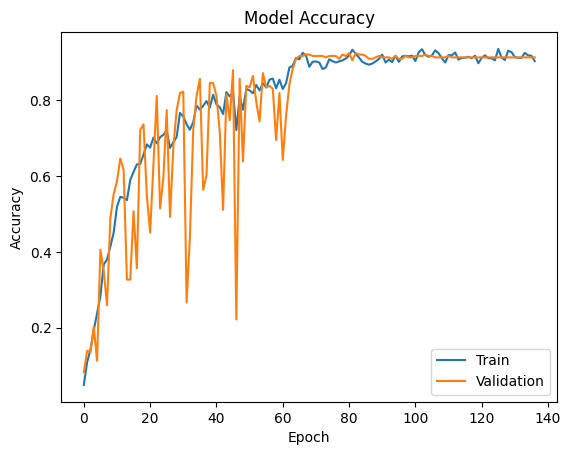

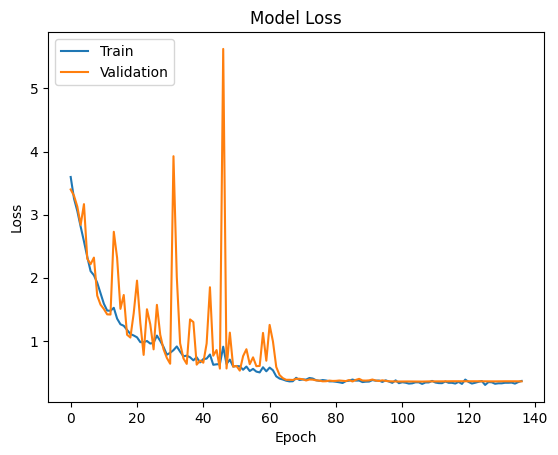

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the Model**

In [17]:
preds = model.predict(x_test)

8/8 [==============================] - 4s 148ms/step


In [18]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 1s 133ms/step - loss: 0.3259 - accuracy: 0.9359


[0.3258969783782959, 0.9358974099159241]

**ٍSave the Model**

In [19]:
model.save('final_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
